In [107]:
import os,sys,struct
import tifffile
import numpy as np
import json, glob
import datajoint as dj
from datetime import datetime
import pandas as pd
from concurrent.futures import ProcessPoolExecutor,ThreadPoolExecutor
from brain_atlas_toolkit import graph_tools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Connect to db
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
dj.config['database.user'] = os.environ.get('DJ_DB_USER')
dj.config['database.password'] = os.environ.get('DJ_DB_PASS')
dj.conn()

Connecting ahoag@datajoint00.pni.princeton.edu:3306


DataJoint connection (connected) ahoag@datajoint00.pni.princeton.edu:3306

In [3]:
db = dj.create_virtual_module('_','ahoag_mouselight_test')

In [4]:
db.Neuron()

idstring,sample_date,sample_strain,virus_label,fluorophore_label,annotation_space,soma_atlas_id,axonal_endpoint_dict
AA0001,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,974,=BLOB=
AA0002,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,=BLOB=
AA0003,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,943,=BLOB=
AA0004,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,=BLOB=


## Load the CCFv3 annotation volume and segment properties 

In [25]:
annotation_file_25micron = '/jukebox/LightSheetData/atlas/allen_atlas/annotation_2017_25um_sagittal_forDVscans.tif'

In [26]:
ann25=tifffile.imread(annotation_file_25micron)

In [27]:
ann25.shape

(456, 528, 320)

In [17]:
segment_props_file = '/jukebox/LightSheetData/atlas/allen_atlas/allenatlas_2017_16bit_hierarch_labels_segment_properties_info'
with open(segment_props_file,'r') as infile:
    segment_props = json.load(infile)

## Load a single neuron as a test

In [28]:
neuron_json_file = '/jukebox/wang/ahoag/mouselight/data/AA1544.json'
with open(neuron_json_file,'r') as infile:
    neuron_data = json.load(infile)

In [29]:
neuron = neuron_data['neurons'][0]

In [35]:
neuron['annotationSpace']

{'version': 3,
 'description': 'Annotation Space: CCFv3.0 Axes> X: Anterior-Posterior; Y: Inferior-Superior; Z:Left-Right'}

In [30]:
soma = neuron['soma']
soma

{'x': 4406.578655875, 'y': 1791.1994315, 'z': 4734.84076775, 'allenId': 767}

In [ ]:
# old:
# x: AP
# y: DV
# z: ML

# new:
# x: DV
# y: AP
# z: ML

# Need to swap old -> new:
# x -> y
# y -> x
# z -> z

In [37]:
# These are in microns in the 10 micron / voxel space. First need to get them in voxels
# Then downsample to to 25 micron / voxels and swap their axes
newx = soma['y']/10/2.5
newy = soma['x']/10/2.5
newz = soma['z']/10/2.5
(newx,newy,newz)

(71.64797725999999, 176.26314623499997, 189.39363071)

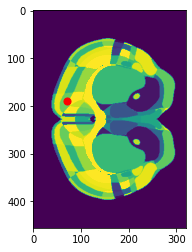

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(ann25[:,176,:],vmin=0,vmax=1000)
ax.scatter([newx],[newz],s=50,color='r')
# ax.set_xlim(100,500)
# ax.set_ylim(100,400)

In [132]:
# This is the same coronal plane so it looks like the ML mapping worked
# Also looks like the DV mapping worked since the point is the correct AP distance. 
# The only thing that looks like it  needs adjustment is the ML, which needs to be mirrored.
# Actually, it turns out that it is just the way this brain is displayed here. In Neuroglancer we don't want to 
# mirror in ML

In [105]:
# OK, now let's try transforming all of the points from this neuron and then make a precomputed layer to overlay on Allen 
neuron.keys()

dict_keys(['idString', 'DOI', 'sample', 'label', 'annotationSpace', 'soma', 'axon', 'dendrite', 'allenInformation'])

In [152]:
neuron

{'idString': 'AA1544',
 'DOI': 'n/a',
 'sample': {'date': '2018-12-01T05:00:00.000Z', 'strain': 'Sim1-Cre'},
 'label': {'virus': 'PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp',
  'fluorophore': 'Immunolabeled with anti-GFP, Alexa-488'},
 'annotationSpace': {'version': 2.5,
  'description': 'Annotation Space: CCFv2.5 (ML legacy) Axes> Z: Anterior-Posterior; Y: Inferior-Superior; X:Left-Right'},
 'soma': {'x': 4734.84076775,
  'y': 1791.1994315,
  'z': 4406.578655875,
  'allenId': 1021},
 'axon': [{'sampleNumber': 1,
   'structureIdentifier': 1,
   'x': 4734.84076775,
   'y': 1791.1994315,
   'z': 4406.578655875,
   'radius': 1,
   'parentNumber': -1,
   'allenId': 1021},
  {'sampleNumber': 2,
   'structureIdentifier': 2,
   'x': 4734.84076775,
   'y': 1792.1003425,
   'z': 4399.597877875,
   'radius': 1,
   'parentNumber': 1,
   'allenId': 1021},
  {'sampleNumber': 3,
   'structureIdentifier': 2,
   'x': 4727.33941025,
   'y': 1805.14955975,
   'z': 4410.384079125,
   'radius': 1,
 

In [40]:
axon = neuron['axon']

In [41]:
len(axon)

3784

In [42]:
neuron['label']

{'virus': 'PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp',
 'fluorophore': 'Immunolabeled with anti-GFP, Alexa-488'}

In [43]:
len(neuron['dendrite'])

1473

## Skeletonizing mouselight Neuron

In [53]:
neuron['idString']

'AA1544'

In [51]:
neuron['soma']

{'x': 4406.578655875, 'y': 1791.1994315, 'z': 4734.84076775, 'allenId': 767}

In [86]:
s1=set([1,2,3])
s1.add(3)
s1.add(4)
s1

{1, 2, 3, 4}

In [111]:
### Soma
ID_soma = 0 # Use 0 for soma, 1 for axon and 2 for dendrite
coordinates_soma = []
neuron_name = neuron['idString']
soma = neuron['soma']
# Downsample to to 25 micron / voxels and swap axes
newx = soma['y']/10/2.5
newy = soma['x']/10/2.5
newz = soma['z']/10/2.5 
coordinates_soma= [[newx,newy,newz]]
vertex_positions_soma = np.array(coordinates_soma,dtype='<f4')
edges_soma = np.array([],dtype='<u4')
filename_soma = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_soma}"
with open(filename_soma,'wb') as outfile:
    buf = struct.pack('<II', vertex_positions_soma.shape[0], edges_soma.shape[0])
    buf += vertex_positions_soma.tobytes()
    buf += edges_soma.tobytes()
    outfile.write(buf)
print("Wrote ",filename_soma)

### Axon
ID_axon = 1
axon = neuron['axon']
coordinates_axon = []
edges_axon = []
axon_branches_dict = {}
axon_terminals_dict = {}
for pt_index,pt in enumerate(axon):
   # Downsample to to 25 micron / voxels and swap their axes
    newx = pt['y']/10/2.5
    newy = pt['x']/10/2.5
    newz = pt['z']/10/2.5 
    sample_number = pt['sampleNumber']-1
    parent_number = pt['parentNumber']-1
    coordinates_axon.append([newx,newy,newz])
    if parent_number >= 0:
        edges_axon.append([parent_number,sample_number])
    # Have to deal with axon splits and terminals
        if (sample_number != parent_number + 1):
            # then the parent is at a branch split and child is at an endpoint
            atlas_id = pt['allenId']
            atlas_id_parent = axon[pt_index-1]['allenId']
            try:
                axon_branches_dict[atlas_id_parent] +=1
            except: 
                axon_branches_dict[atlas_id_parent] = 1
            try:
                axon_terminals_dict[atlas_id] += 1
            except:
                axon_terminals_dict[atlas_id] = 1
    
vertex_positions_axon = np.array(coordinates_axon,dtype='<f4')
edges_axon = np.array(edges_axon,dtype='<u4')
# edges_axon = np.array([],dtype='<u4')
filename_axon = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_axon}"
with open(filename_axon,'wb') as outfile:
    buf = struct.pack('<II', vertex_positions_axon.shape[0], edges_axon.shape[0])
    buf += vertex_positions_axon.tobytes()
    buf += edges_axon.tobytes()
    outfile.write(buf)
print("Wrote ",filename_axon)

### Dendrite
ID_dendrite = 2
dendrite = neuron['dendrite']
coordinates_dendrite = []
edges_dendrite = []
dendrite_branches_dict = {}
dendrite_terminals_dict = {}
for pt_index,pt in enumerate(dendrite):
   # Downsample to to 25 micron / voxels and swap their axes
    newx = pt['y']/10/2.5
    newy = pt['x']/10/2.5
    newz = pt['z']/10/2.5 
    coordinates_dendrite.append([newx,newy,newz])
    sample_number = pt['sampleNumber']-1
    parent_number = pt['parentNumber']-1
    if parent_number >= 0:
        edges_dendrite.append([parent_number,sample_number])
        if (sample_number != parent_number + 1):
            # then the parent is at a branch split and child is at an endpoint
            atlas_id = pt['allenId']
            atlas_id_parent = dendrite[pt_index-1]['allenId']
            try:
                dendrite_branches_dict[atlas_id_parent] +=1
            except: 
                dendrite_branches_dict[atlas_id_parent] = 1
            try:
                dendrite_terminals_dict[atlas_id] += 1
            except:
                dendrite_terminals_dict[atlas_id] = 1

vertex_positions_dendrite = np.array(coordinates_dendrite,dtype='<f4')
edges_dendrite = np.array(edges_dendrite,dtype='<u4')
filename_dendrite = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_dendrite}"
with open(filename_dendrite,'wb') as outfile:
    buf = struct.pack('<II', vertex_positions_dendrite.shape[0], edges_dendrite.shape[0])
    buf += vertex_positions_dendrite.tobytes()
    buf += edges_dendrite.tobytes()
    outfile.write(buf)
print("Wrote ",filename_dendrite)

Wrote  /jukebox/LightSheetData/neuroglancer/public/mouselight/AA1544/0
Wrote  /jukebox/LightSheetData/neuroglancer/public/mouselight/AA1544/1
Wrote  /jukebox/LightSheetData/neuroglancer/public/mouselight/AA1544/2


In [62]:
# Save segment properties 
segment_props_neuron = {}
segment_props_neuron['@type'] = 'neuroglancer_segment_properties'
segment_props_neuron['inline'] = {
    'ids': ['0','1','2'],
    'properties':[
        {
            'id':'label',
            'type':'label',
            'values': [
                f'{neuron_name}: soma',
                f'{neuron_name}: axon',
                f'{neuron_name}: dendrite'
            ]
        }
    ]
}
segment_props_neuron_filename = f'/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/segment_properties/info'
with open(segment_props_neuron_filename,'w') as outfile:
    json.dump(segment_props_neuron,outfile,indent=2)
print(f"Saved {segment_props_neuron_filename}")

Saved /jukebox/LightSheetData/neuroglancer/public/mouselight/AA1544/segment_properties/info


In [66]:
# Save info file
info = {
    "@type": "neuroglancer_skeletons",
    "transform": [25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0],
    "vertex_attributes":[],
    "segment_properties":"segment_properties"
}
info_filename = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/info"
with open(info_filename,'w') as outfile:
    json.dump(info,outfile)
print("Wrote ",info_filename)

Wrote  /jukebox/LightSheetData/neuroglancer/public/mouselight/AA1544/info


## Ingest neurons into test database 

In [112]:
neuron

{'idString': 'AA1544',
 'DOI': 'n/a',
 'sample': {'date': '2018-12-01T05:00:00.000Z', 'strain': 'Sim1-Cre'},
 'label': {'virus': 'PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp',
  'fluorophore': 'Immunolabeled with anti-GFP, Alexa-488'},
 'annotationSpace': {'version': 3,
  'description': 'Annotation Space: CCFv3.0 Axes> X: Anterior-Posterior; Y: Inferior-Superior; Z:Left-Right'},
 'soma': {'x': 4406.578655875,
  'y': 1791.1994315,
  'z': 4734.84076775,
  'allenId': 767},
 'axon': [{'sampleNumber': 1,
   'structureIdentifier': 1,
   'x': 4406.578655875,
   'y': 1791.1994315,
   'z': 4734.84076775,
   'radius': 1,
   'parentNumber': -1,
   'allenId': 767},
  {'sampleNumber': 2,
   'structureIdentifier': 2,
   'x': 4399.597877875,
   'y': 1792.1003425,
   'z': 4734.84076775,
   'radius': 1,
   'parentNumber': 1,
   'allenId': 767},
  {'sampleNumber': 3,
   'structureIdentifier': 2,
   'x': 4410.384079125,
   'y': 1805.14955975,
   'z': 4727.33941025,
   'radius': 1,
   'parentNumber':

In [114]:
soma

{'x': 4406.578655875, 'y': 1791.1994315, 'z': 4734.84076775, 'allenId': 767}

## Read in all neurons

In [8]:
neuron_dir = '/home/ahoag/progs/mouselight/public/json30'
json_files = sorted(glob.glob(neuron_dir + '/*json'))

In [153]:
json_files

['/home/ahoag/progs/mouselight/public/json30/AA0001.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0002.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0003.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0004.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0005.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0006.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0007.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0008.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0009.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0010.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0011.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0012.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0013.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0014.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0015.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0016.json',
 '/home/ahoag/progs/mouselight/public/json30/AA0017.json

In [5]:
def write_skeletons(neuron,debug=False):
    # Make directory if it does not exist already
    neuron_name = neuron['idString']
    neuron_dir = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}"
    os.makedirs(neuron_dir,exist_ok=True) 
    ### Soma
    ID_soma = 0 # Use 0 for soma, 1 for axon and 2 for dendrite
    coordinates_soma = []
    soma = neuron['soma']
    # Downsample to to 25 micron / voxels and swap axes
    newx = soma['y']/10/2.5
    newy = soma['x']/10/2.5
    newz = soma['z']/10/2.5 
    coordinates_soma= [[newx,newy,newz]]
    vertex_positions_soma = np.array(coordinates_soma,dtype='<f4')
    edges_soma = np.array([],dtype='<u4')
    filename_soma = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_soma}"
    with open(filename_soma,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_soma.shape[0], edges_soma.shape[0])
        buf += vertex_positions_soma.tobytes()
        buf += edges_soma.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_soma)
    
    ### Axon
    ID_axon = 1
    axon = neuron['axon']
    coordinates_axon = []
    edges_axon = []
    axon_branches_dict = {}
    axon_terminals_dict = {}
    for pt_index,pt in enumerate(axon):
       # Downsample to to 25 micron / voxels and swap their axes
        newx = pt['y']/10/2.5
        newy = pt['x']/10/2.5
        newz = pt['z']/10/2.5 
        sample_number = pt['sampleNumber']-1
        parent_number = pt['parentNumber']-1
        coordinates_axon.append([newx,newy,newz])
        if parent_number >= 0:
            edges_axon.append([parent_number,sample_number])
        # Have to deal with axon splits and terminals
            if (sample_number != parent_number + 1):
                # then the parent is at a branch split and child is at an endpoint
                atlas_id = pt['allenId']
                atlas_id_parent = axon[pt_index-1]['allenId']
                try:
                    axon_branches_dict[atlas_id_parent] +=1
                except: 
                    axon_branches_dict[atlas_id_parent] = 1
                try:
                    axon_terminals_dict[atlas_id] += 1
                except:
                    axon_terminals_dict[atlas_id] = 1

    vertex_positions_axon = np.array(coordinates_axon,dtype='<f4')
    edges_axon = np.array(edges_axon,dtype='<u4')
    # edges_axon = np.array([],dtype='<u4')
    filename_axon = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_axon}"
    with open(filename_axon,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_axon.shape[0], edges_axon.shape[0])
        buf += vertex_positions_axon.tobytes()
        buf += edges_axon.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_axon)

    ### Dendrite
    ID_dendrite = 2
    dendrite = neuron['dendrite']
    coordinates_dendrite = []
    edges_dendrite = []
    dendrite_branches_dict = {}
    dendrite_terminals_dict = {}
    for pt_index,pt in enumerate(dendrite):
       # Downsample to to 25 micron / voxels and swap their axes
        newx = pt['y']/10/2.5
        newy = pt['x']/10/2.5
        newz = pt['z']/10/2.5 
        coordinates_dendrite.append([newx,newy,newz])
        sample_number = pt['sampleNumber']-1
        parent_number = pt['parentNumber']-1
        if parent_number >= 0:
            edges_dendrite.append([parent_number,sample_number])
            if (sample_number != parent_number + 1):
                # then the parent is at a branch split and child is at an endpoint
                atlas_id = pt['allenId']
                atlas_id_parent = dendrite[pt_index-1]['allenId']
                try:
                    dendrite_branches_dict[atlas_id_parent] +=1
                except: 
                    dendrite_branches_dict[atlas_id_parent] = 1
                try:
                    dendrite_terminals_dict[atlas_id] += 1
                except:
                    dendrite_terminals_dict[atlas_id] = 1

    vertex_positions_dendrite = np.array(coordinates_dendrite,dtype='<f4')
    edges_dendrite = np.array(edges_dendrite,dtype='<u4')
    filename_dendrite = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/{ID_dendrite}"
    with open(filename_dendrite,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_dendrite.shape[0], edges_dendrite.shape[0])
        buf += vertex_positions_dendrite.tobytes()
        buf += edges_dendrite.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_dendrite)
    
    ### Segment properties
    # Save segment properties 
    segment_props_neuron = {}
    segment_props_neuron['@type'] = 'neuroglancer_segment_properties'
    segment_props_neuron['inline'] = {
        'ids': ['0','1','2'],
        'properties':[
            {
                'id':'label',
                'type':'label',
                'values': [
                    f'{neuron_name}: soma',
                    f'{neuron_name}: axon',
                    f'{neuron_name}: dendrite'
                ]
            }
        ]
    }
    segment_props_neuron_dir = f'/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/segment_properties'
    os.makedirs(segment_props_neuron_dir,exist_ok=True)
    segment_props_neuron_filename = os.path.join(segment_props_neuron_dir,'info')
    with open(segment_props_neuron_filename,'w') as outfile:
        json.dump(segment_props_neuron,outfile,indent=2)
    if debug:
        print(f"Saved {segment_props_neuron_filename}")
    
    # Save info file
    info = {
        "@type": "neuroglancer_skeletons",
        "transform": [25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0],
        "vertex_attributes":[],
        "segment_properties":"segment_properties"
    }
    info_filename = f"/jukebox/LightSheetData/neuroglancer/public/mouselight/{neuron_name}/info"
    with open(info_filename,'w') as outfile:
        json.dump(info,outfile)
    if debug:
        print("Wrote ",info_filename)
    
    return soma,axon_terminals_dict,axon_branches_dict,dendrite_terminals_dict,dendrite_branches_dict

In [283]:
def process(neuron_json_file):
    with open(neuron_json_file,'r') as infile:
        neuron_data = json.load(infile)
        neuron = neuron_data['neuron']
        soma,axon_terminals_dict,axon_branches_dict,dendrite_terminals_dict,dendrite_branches_dict = write_skeletons(neuron)
        # Insert into db
        neuron_insert_dict = {}
        neuron_insert_dict['idstring'] = neuron['idString']
        neuron_insert_dict['sample_date'] = datetime.strptime(neuron['sample']['date'],"%Y-%m-%dT%H:%M:%S.%fZ")
        neuron_insert_dict['sample_strain'] = neuron['sample']['strain']
        neuron_insert_dict['virus_label'] = neuron['label']['virus']
        neuron_insert_dict['fluorophore_label'] = neuron['label']['fluorophore']
        neuron_insert_dict['annotation_space'] = "ccfv3_25um"
        if soma['allenId']:
            neuron_insert_dict['soma_atlas_id'] = soma['allenId']   
            
        neuron_insert_dict['axonal_endpoint_dict'] = {"count_"+str(key):val for key,val in axon_terminals_dict.items()}
        print(neuron_insert_dict['axonal_endpoint_dict'])
        return neuron_insert_dict
    

# db_ml.Neuron().insert(neuron_insert_list,skip_duplicates=True)

In [284]:
# %%time
neuron_insert_list = []
ii=0
with ProcessPoolExecutor(max_workers=12) as executor:
    for neuron_insert_dict in executor.map(process,json_files[:10]):
        try:
            neuron_insert_list.append(neuron_insert_dict)
            ii+=1
            print(ii,neuron_insert_dict['idstring'])
        except Exception as exc:
            print(f'generated an exception: {exc}')
# print(neuron_insert_list)
            # db_ml.Neuron().insert(neuron_insert_list,skip_duplicates=True)

1 AA0001
2 AA0002
3 AA0003
4 AA0004
5 AA0005
6 AA0006
7 AA0007
8 AA0008
9 AA0009
10 AA0010


In [290]:
neuron_insert_list[0]

{'idstring': 'AA0001',
 'sample_date': datetime.datetime(2015, 6, 19, 12, 0),
 'sample_strain': 'C57BL/6J',
 'virus_label': 'AAV2/1.FLEX-eGFP',
 'fluorophore_label': 'eGFP',
 'annotation_space': 'ccfv3_25um',
 'soma_atlas_id': 974,
 'axonal_endpoint_dict': {'count_625': 10,
  'count_648': 15,
  'count_974': 29,
  'count_1102': 24,
  'count_945': 4,
  'count_1058': 6,
  'count_857': 1,
  'count_672': 241,
  'count_422': 2,
  'count_128': 1,
  'count_313': 2,
  'count_685': 1,
  'count_549': 2,
  'count_366': 1,
  'count_1097': 1,
  'count_364': 1,
  'count_381': 1,
  'count_931': 4,
  'count_1031': 1,
  'count_1009': 1,
  'count_1022': 1,
  'count_262': 1,
  'count_1020': 8,
  'count_733': 1,
  'count_484682512': 2,
  'count_882': 1,
  'count_844': 6,
  'count_767': 3,
  'count_1021': 1,
  'count_526157196': 3,
  'count_440': 1,
  'count_878': 10,
  'count_657': 3,
  'count_854': 2}}

In [285]:
# Make pandas dataframe
df=pd.DataFrame(neuron_insert_list)

In [287]:
df.to_csv('/home/ahoag/progs/mouselight/data/mouselight_neurons_test.csv')

In [103]:
len(df)

1111

In [151]:
# Save dataframe to csv
df.to_csv('/home/ahoag/progs/mouselight/data/all_mouselight_neurons.csv')

In [194]:
%%time
df2 = pd.read_csv('/home/ahoag/progs/mouselight/data/all_mouselight_neurons.csv')

CPU times: user 10.9 ms, sys: 6.82 ms, total: 17.7 ms
Wall time: 16.1 ms


## Alt method: write all neuron skeletons to same directory
This will reduce the number of layers created when someone wants to view multiple neurons. The only thing we'll have to worry about here is making it clear what integer ids correspond to what neurons. Can just use 0,1,2 for soma, axon, dendrite of first neuron, 3,4,5 for soma, axon and dendrite of second neuron and so on. Use segment properties to keep all this straight. 

In [182]:
def write_skeletons_singledir(neuron,ID_soma, debug=False):
    # Make directory if it does not exist already
    precomputed_dir = "/jukebox/LightSheetData/neuroglancer/public/mouselight/all_neurons/"
    
    ### Soma
    coordinates_soma = []
    soma = neuron['soma']
    
    # Downsample to to 25 micron / voxels and swap axes
    newx = soma['y']/10/2.5
    newy = soma['x']/10/2.5
    newz = soma['z']/10/2.5 
    coordinates_soma= [[newx,newy,newz]]
    vertex_positions_soma = np.array(coordinates_soma,dtype='<f4')
    edges_soma = np.array([],dtype='<u4')
    
    filename_soma = os.path.join(precomputed_dir,str(ID_soma))
    with open(filename_soma,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_soma.shape[0], edges_soma.shape[0])
        buf += vertex_positions_soma.tobytes()
        buf += edges_soma.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_soma)
    
    ### Axon
    ID_axon = ID_soma + 1
    axon = neuron['axon']
    
    coordinates_axon = []
    edges_axon = []
    axon_branches_dict = {}
    axon_terminals_dict = {}
    for pt_index,pt in enumerate(axon):
       # Downsample to to 25 micron / voxels and swap their axes
        newx = pt['y']/10/2.5
        newy = pt['x']/10/2.5
        newz = pt['z']/10/2.5 
        sample_number = pt['sampleNumber']-1
        parent_number = pt['parentNumber']-1
        coordinates_axon.append([newx,newy,newz])
        if parent_number >= 0:
            edges_axon.append([parent_number,sample_number])
            # Have to deal with axon splits and terminals
            if (sample_number != parent_number + 1):
                # then the parent is at a branch split and child is at an endpoint
                atlas_id = pt['allenId']
                atlas_id_parent = axon[pt_index-1]['allenId']
                try:
                    axon_branches_dict[atlas_id_parent] +=1
                except: 
                    axon_branches_dict[atlas_id_parent] = 1
                try:
                    axon_terminals_dict[atlas_id] += 1
                except:
                    axon_terminals_dict[atlas_id] = 1

    vertex_positions_axon = np.array(coordinates_axon,dtype='<f4')
    edges_axon = np.array(edges_axon,dtype='<u4')
    
    filename_axon = os.path.join(precomputed_dir,str(ID_axon))
    with open(filename_axon,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_axon.shape[0], edges_axon.shape[0])
        buf += vertex_positions_axon.tobytes()
        buf += edges_axon.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_axon)

    ### Dendrite
    ID_dendrite = ID_soma + 2
    dendrite = neuron['dendrite']
    
    coordinates_dendrite = []
    edges_dendrite = []
    dendrite_branches_dict = {}
    dendrite_terminals_dict = {}
    for pt_index,pt in enumerate(dendrite):
       # Downsample to to 25 micron / voxels and swap their axes
        newx = pt['y']/10/2.5
        newy = pt['x']/10/2.5
        newz = pt['z']/10/2.5 
        coordinates_dendrite.append([newx,newy,newz])
        sample_number = pt['sampleNumber']-1
        parent_number = pt['parentNumber']-1
        if parent_number >= 0:
            edges_dendrite.append([parent_number,sample_number])
            if (sample_number != parent_number + 1):
                # then the parent is at a branch split and child is at an endpoint
                atlas_id = pt['allenId']
                atlas_id_parent = dendrite[pt_index-1]['allenId']
                try:
                    dendrite_branches_dict[atlas_id_parent] +=1
                except: 
                    dendrite_branches_dict[atlas_id_parent] = 1
                try:
                    dendrite_terminals_dict[atlas_id] += 1
                except:
                    dendrite_terminals_dict[atlas_id] = 1

    vertex_positions_dendrite = np.array(coordinates_dendrite,dtype='<f4')
    edges_dendrite = np.array(edges_dendrite,dtype='<u4')
    
    filename_dendrite = os.path.join(precomputed_dir,str(ID_dendrite))
    with open(filename_dendrite,'wb') as outfile:
        buf = struct.pack('<II', vertex_positions_dendrite.shape[0], edges_dendrite.shape[0])
        buf += vertex_positions_dendrite.tobytes()
        buf += edges_dendrite.tobytes()
        outfile.write(buf)
    if debug:
        print("Wrote ",filename_dendrite)
    
    
    return True

In [187]:
def process_singledir(neuron_json_file):
    with open(neuron_json_file,'r') as infile:
        neuron_data = json.load(infile)
    neuron = neuron_data['neuron']
    ID_soma = json_files.index(neuron_json_file)*3
    print("ID:")
    print(ID_soma)
    return write_skeletons_singledir(neuron,ID_soma,debug=False)

In [189]:
with ProcessPoolExecutor(max_workers=12) as executor:
    for res in executor.map(process_singledir,json_files):
        try:
            print(res)
        except Exception as exc:
            print(f'generated an exception: {exc}')


ID:ID:
ID:
ID:27
15

9ID:


ID:ID:
21
300

6
ID:

ID:ID:
1233


18ID:

3
ID:
24
ID:
36
ID:
39
ID:
42
ID:
45
ID:
48
ID:
51
ID:
54
ID:
57
ID:
60
True
True
True
ID:
63
ID:
66
ID:
69
True
True
True
True
True
True
True
True
True
ID:
72
True
ID:
75
ID:
78
True
True
ID:
81
True
ID:
84
ID:
87
ID:
90
ID:
93
True
True
True
ID:
96
True
True
True
ID:
99
ID:
102
ID:
105
True
True
ID:
108
True
ID:
111
ID:
114
True
ID:
117
ID:
120
True
True
ID:
123
ID:
126
ID:
129
ID:
132
True
True
True
True
True
ID:
135
ID:
138
ID:
141
True
True
True
ID:
144
True
ID:
147
ID:
150
ID:
153
ID:
156
True
True
True
True
ID:
159
ID:
162
True
True
ID:
165
True
ID:
168
ID:
171
ID:
174
ID:
177
True
True
True
True
ID:
180
True
ID:
183
ID:
186
ID:
189
ID:True
True
True
True

192
ID:
195
ID:
198
ID:
201
ID:
204
ID:
207
True
True
ID:
210
ID:
213
True
True
True
True
True
ID:
216
True
ID:
219
ID:
222
ID:
225
ID:
228
ID:
231
True
True
True
True
True
ID:
234
ID:
237
True
True
ID:
240
ID:
243
True
True
ID:
246
ID:
249
True
True
ID:
25

In [176]:
### Segment properties
# Save segment properties 
segment_props_neuron = {}
segment_props_neuron['@type'] = 'neuroglancer_segment_properties'
segment_props_neuron['inline'] = {
    'ids': [],
    'properties':[
        {
            'id':'label',
            'type':'label',
            'values': []
        }
    ]
}
skeleton_ids = [str(x) for x in range(len(json_files)*3)]
neuron_names = [os.path.basename(x).split('.')[0] for x in json_files]
skeleton_names = [name + ': ' + feature for name in neuron_names for feature in ['soma','axon','dendrite']]

segment_props_neuron['inline']['ids'] = skeleton_ids
segment_props_neuron['inline']['properties'][0]['values'] = skeleton_names 

segment_props_neuron_dir = '/jukebox/LightSheetData/neuroglancer/public/mouselight/all_neurons/segment_properties'
os.makedirs(segment_props_neuron_dir,exist_ok=True)

segment_props_neuron_filename = os.path.join(segment_props_neuron_dir,'info')
with open(segment_props_neuron_filename,'w') as outfile:
    json.dump(segment_props_neuron,outfile,indent=2)
print(f"Saved {segment_props_neuron_filename}")

# Save info file
info = {
    "@type": "neuroglancer_skeletons",
    "transform": [25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0, 0.0, 0.0, 0.0, 25000, 0.0],
    "vertex_attributes":[],
    "segment_properties":"segment_properties"
}
info_filename = '/jukebox/LightSheetData/neuroglancer/public/mouselight/all_neurons/info'
with open(info_filename,'w') as outfile:
    json.dump(info,outfile,indent=2)

print("Saved ",info_filename)

Saved /jukebox/LightSheetData/neuroglancer/public/mouselight/all_neurons/segment_properties/info
Saved  /jukebox/LightSheetData/neuroglancer/public/mouselight/all_neurons/info


## Test speed of filtering for number of axonal endpoints > thresh, e.g.

If we want to know how many endpoints there are in a large parent region like the Cerebellum, the number we get back is only going to tell us how many there are in a shell. So what we first need to do is to figure out all child regions of the region requested and if there are any, we then need to sum up the counts in the requested region plus counts in all child regions. 

In [109]:
allen_ontology_file = '/jukebox/LightSheetData/atlas/allen_atlas/allen.json'
with open(allen_ontology_file,'r') as infile:
    ontology_dict = json.load(infile)

In [111]:
graph = graph_tools.Graph(ontology_dict)

In [205]:
def filter_by_region(dic, allenID, thresh, operation):
    """ A function that checks if dic[f'counts_{allenID}'] (operation) thresh
    and handles the case where key not in dic.
    
    operation can be one of 'ge', 'le', or 'eq'
    """
    dic = eval(dic)
    # First get region name 
    allen_name = graph.lookup_region_name_by_id(allenID)
    # get all progeny (by name) 
    progeny_byname = graph.get_progeny(allen_name)
    all_regions_byid = [allenID] + [graph.get_id(name) for name in progeny_byname]
    total_count = 0
    for ID in all_regions_byid:
        key = f'count_{ID}'
        if key not in dic:
            continue 
        total_count += dic[key]
    if operation == 'ge':
        return total_count >= thresh
    elif operation == 'le':
        return total_count <= thresh
    elif operation == 'eq':
        return total_count == thresh
    else:
        sys.exit(1)

In [226]:
df2

,Unnamed: 0,idstring,sample_date,sample_strain,virus_label,fluorophore_label,annotation_space,soma_atlas_id,axonal_endpoint_dict
0,0,AA0001,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,974,"{'count_625': 10, 'count_648': 15, 'count_974'..."
1,1,AA0002,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,"{'count_625': 24, 'count_648': 42, 'count_854'..."
2,2,AA0003,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,943,"{'count_943': 151, 'count_648': 38, 'count_844..."
3,3,AA0004,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,"{'count_625': 20, 'count_648': 40, 'count_943'..."
4,4,AA0005,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,844,"{'count_1101': 2, 'count_783': 3, 'count_1108'..."
...,...,...,...,...,...,...,...,...,...
1106,1106,AA1541,2018-12-01 05:00:00,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,767,"{'count_354': 8, 'count_1048': 5, 'count_852':..."
1107,1107,AA1542,2018-12-01 05:00:00,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,844,"{'count_574': 5, 'count_190': 1, 'count_1048':..."
1108,1108,AA1543,2018-12-01 05:00:00,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,767,"{'count_931': 35, 'count_784': 2, 'count_83': ..."
1109,1109,AA1544,2018-12-01 05:00:00,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flp,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,767,"{'count_354': 1, 'count_697': 2, 'count_771': ..."


In [295]:
%%time
res=df2.loc[df2['axonal_endpoint_dict'].apply(lambda x: eval(x)['count_625']>=11 if 'count_625' in x else False)]
res

CPU times: user 13.3 ms, sys: 21 µs, total: 13.3 ms
Wall time: 12.4 ms


,Unnamed: 0,idstring,sample_date,sample_strain,virus_label,fluorophore_label,annotation_space,soma_atlas_id,axonal_endpoint_dict
1,1,AA0002,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,"{'count_625': 24, 'count_648': 42, 'count_854'..."
3,3,AA0004,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,648,"{'count_625': 20, 'count_648': 40, 'count_943'..."
6,6,AA0007,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,854,"{'count_484682512': 1, 'count_844': 8, 'count_..."
7,7,AA0008,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,854,"{'count_962': 6, 'count_767': 9, 'count_1021':..."
41,41,AA0042,2016-07-18 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,844,"{'count_1090': 12, 'count_862': 4, 'count_1070..."
309,309,AA0310,2017-09-11 18:52:55,C57BL/6J,AAV 2/5 Cre + GFP,eGFP,ccfv3_25um,733,"{'count_1092': 3, 'count_262': 4, 'count_718':..."
312,312,AA0313,2017-09-11 18:52:55,C57BL/6J,AAV 2/5 Cre + GFP,eGFP,ccfv3_25um,733,"{'count_718': 8, 'count_1092': 2, 'count_262':..."
580,580,AA0581,2018-04-03 15:08:17,C57BL/6N,AAV2/5 Cre + AAV2/1 GFP,immuno labeled for anti-GFP,ccfv3_25um,1020,"{'count_718': 8, 'count_648': 134, 'count_943'..."
611,611,AA0612,2018-04-13 15:28:33,C57BL/6N,AAV2/5 Cre + AAV2/5 tDT,immuno labeled for anti-tDT,ccfv3_25um,629,"{'count_943': 41, 'count_648': 218, 'count_844..."
616,616,AA0617,2018-04-13 15:28:33,C57BL/6N,AAV2/1 Cre + AAV2/1 GFP,immuno labeled for anti-GFP,ccfv3_25um,943,"{'count_733': 2, 'count_1020': 20, 'count_262'..."


In [296]:
len(res)

17

In [303]:
graph.get_id('Cerebellum')

512

In [302]:
graph.print_branch('root',stoplevel=2)

 0 root
	 1 Basic cell groups and regions
		 2 Cerebrum
		 2 Brain stem
		 2 Cerebellum
	 1 fiber tracts
		 2 cranial nerves
		 2 cerebellum related fiber tracts
		 2 supra-callosal cerebral white matter
		 2 lateral forebrain bundle system
		 2 extrapyramidal fiber systems
		 2 medial forebrain bundle system
	 1 ventricular systems
		 2 lateral ventricle
		 2 interventricular foramen
		 2 third ventricle
		 2 cerebral aqueduct
		 2 fourth ventricle
		 2 central canal, spinal cord/medulla
	 1 grooves
		 2 grooves of the cerebral cortex
		 2 grooves of the cerebellar cortex
		 2 Interpeduncular fossa
	 1 retina


' 0 root\n\t 1 Basic cell groups and regions\n\t\t 2 Cerebrum\n\t\t 2 Brain stem\n\t\t 2 Cerebellum\n\t 1 fiber tracts\n\t\t 2 cranial nerves\n\t\t 2 cerebellum related fiber tracts\n\t\t 2 supra-callosal cerebral white matter\n\t\t 2 lateral forebrain bundle system\n\t\t 2 extrapyramidal fiber systems\n\t\t 2 medial forebrain bundle system\n\t 1 ventricular systems\n\t\t 2 lateral ventricle\n\t\t 2 interventricular foramen\n\t\t 2 third ventricle\n\t\t 2 cerebral aqueduct\n\t\t 2 fourth ventricle\n\t\t 2 central canal, spinal cord/medulla\n\t 1 grooves\n\t\t 2 grooves of the cerebral cortex\n\t\t 2 grooves of the cerebellar cortex\n\t\t 2 Interpeduncular fossa\n\t 1 retina\n'

In [298]:
graph.lookup_region_name_by_id(1)

'Tuberomammillary nucleus, ventral part'

In [241]:
len(neurons)

11

In [232]:
ids=[0,1,2]
[id*3+x for id in ids for x in [0,1,2]]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [236]:
neurons.idstring

1       AA0002
3       AA0004
6       AA0007
7       AA0008
309     AA0310
580     AA0581
611     AA0612
691     AA0692
753     AA0754
1031    AA1032
1094    AA1192
Name: idstring, dtype: object

In [239]:
graph.graph.keys()

dict_keys(['root', 'Basic cell groups and regions', 'Cerebrum', 'Cerebral cortex', 'Cortical plate', 'Isocortex', 'Frontal pole, cerebral cortex', 'Frontal pole, layer 1', 'Frontal pole, layer 2/3', 'Frontal pole, layer 5', 'Frontal pole, layer 6a', 'Frontal pole, layer 6b', 'Somatomotor areas', 'Somatomotor areas, Layer 1', 'Somatomotor areas, Layer 2/3', 'Somatomotor areas, Layer 5', 'Somatomotor areas, Layer 6a', 'Somatomotor areas, Layer 6b', 'Primary motor area', 'Primary motor area, Layer 1', 'Primary motor area, Layer 2/3', 'Primary motor area, Layer 5', 'Primary motor area, Layer 6a', 'Primary motor area, Layer 6b', 'Secondary motor area', 'Secondary motor area, layer 1', 'Secondary motor area, layer 2/3', 'Secondary motor area, layer 5', 'Secondary motor area, layer 6a', 'Secondary motor area, layer 6b', 'Somatosensory areas', 'Somatosensory areas, layer 1', 'Somatosensory areas, layer 2/3', 'Somatosensory areas, layer 4', 'Somatosensory areas, layer 5', 'Somatosensory areas, 

In [234]:
[ix*3+x for ix in neurons.index for x in [0,1,2]]

[3,
 4,
 5,
 9,
 10,
 11,
 18,
 19,
 20,
 21,
 22,
 23,
 927,
 928,
 929,
 1740,
 1741,
 1742,
 1833,
 1834,
 1835,
 2073,
 2074,
 2075,
 2259,
 2260,
 2261,
 3093,
 3094,
 3095,
 3282,
 3283,
 3284]

## Look up neurons with soma in Cerebellum and axonal end points in neocortex

In [254]:
graph.get_progeny("Isocortex")

['Frontal pole, cerebral cortex',
 'Frontal pole, layer 1',
 'Frontal pole, layer 2/3',
 'Frontal pole, layer 5',
 'Frontal pole, layer 6a',
 'Frontal pole, layer 6b',
 'Somatomotor areas',
 'Somatomotor areas, Layer 1',
 'Somatomotor areas, Layer 2/3',
 'Somatomotor areas, Layer 5',
 'Somatomotor areas, Layer 6a',
 'Somatomotor areas, Layer 6b',
 'Primary motor area',
 'Primary motor area, Layer 1',
 'Primary motor area, Layer 2/3',
 'Primary motor area, Layer 5',
 'Primary motor area, Layer 6a',
 'Primary motor area, Layer 6b',
 'Secondary motor area',
 'Secondary motor area, layer 1',
 'Secondary motor area, layer 2/3',
 'Secondary motor area, layer 5',
 'Secondary motor area, layer 6a',
 'Secondary motor area, layer 6b',
 'Somatosensory areas',
 'Somatosensory areas, layer 1',
 'Somatosensory areas, layer 2/3',
 'Somatosensory areas, layer 4',
 'Somatosensory areas, layer 5',
 'Somatosensory areas, layer 6a',
 'Somatosensory areas, layer 6b',
 'Primary somatosensory area',
 'Primar

In [270]:
def filter_by_region(dic, allenID, thresh, operation,debug=False):
    """ A function that checks if dic[f'counts_{allenID}'] (operation) thresh
    and handles the case where key not in dic.
    
    operation can be one of 'ge', 'le', or 'eq'
    """
    dic = eval(dic)
    # First get region name 
    allen_name = graph.lookup_region_name_by_id(allenID)
    # get all progeny (by name) 
    progeny_byname = graph.get_progeny(allen_name)
    all_regions_byid = [allenID] + [graph.get_id(name) for name in progeny_byname]
    total_count = 0
    for ID in all_regions_byid:
        if debug:
            print(ID,total_count)
        key = f'count_{ID}'
        if key not in dic:
            continue 
        total_count += dic[key]
    if operation == 'ge':
        return total_count >= thresh
    elif operation == 'le':
        return total_count <= thresh
    elif operation == 'eq':
        return total_count == thresh
    else:
        sys.exit(1)

In [278]:
cb_name = 'Cerebellum'
cb_id = graph.get_id(cb_name)
progeny_byname = graph.get_progeny(cb_name)
all_regions_cb = [cb_id] + [graph.get_id(name) for name in progeny_byname]
mask_cb = df2.soma_atlas_id.isin(all_regions_byid)

iso_name = 'Thalamus'
iso_id = graph.get_id(iso_name)
df2_cb = df2.loc[mask_cb]
mask_iso = df2['axonal_endpoint_dict'].apply(filter_by_region,args=(iso_id,10,'ge'))
df2.loc[mask_iso]

,Unnamed: 0,idstring,sample_date,sample_strain,virus_label,fluorophore_label,annotation_space,soma_atlas_id,axonal_endpoint_dict
0,0,AA0001,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,974,"{'count_625': 10, 'count_648': 15, 'count_974'..."
10,10,AA0011,2015-06-19 12:00:00,C57BL/6J,AAV2/1.FLEX-tdTomato,tdTomato,ccfv3_25um,767,"{'count_215': 17, 'count_128': 34, 'count_17':..."
14,14,AA0015,2017-01-15 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,255,"{'count_262': 14, 'count_542': 116, 'count_Non..."
15,15,AA0016,2017-01-15 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,255,"{'count_255': 7, 'count_262': 7, 'count_1009':..."
16,16,AA0017,2017-01-15 12:00:00,C57BL/6J,AAV2/1.FLEX-eGFP,eGFP,ccfv3_25um,351,"{'count_1097': 122, 'count_63': 7, 'count_88':..."
...,...,...,...,...,...,...,...,...,...
1068,1068,AA1069,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,437,"{'count_797': 242, 'count_10': 56, 'count_313'..."
1078,1078,AA1079,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,728,"{'count_17': 57, 'count_10': 65, 'count_628': ..."
1087,1087,AA1088,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1102,"{'count_262': 2, 'count_733': 27}"
1089,1089,AA1090,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1037,"{'count_443': 5, 'count_1037': 2, 'count_1104'..."


In [277]:
df2_cb['axonal_endpoint_dict']

428     {'count_728': 8, 'count_989': 4, 'count_91': 2...
960     {'count_91': 63, 'count_728': 10, 'count_984':...
961     {'count_1049': 21, 'count_None': 1, 'count_867...
962     {'count_217': 9, 'count_202': 15, 'count_867':...
964     {'count_951': 3, 'count_1033': 2, 'count_91': ...
965     {'count_91': 20, 'count_728': 2, 'count_512': ...
966     {'count_91': 19, 'count_728': 27, 'count_1033'...
968     {'count_728': 24, 'count_91': 25, 'count_1091'...
969     {'count_91': 39, 'count_728': 4, 'count_1007': 8}
970     {'count_976': 6, 'count_728': 1, 'count_989': ...
971     {'count_202': 3, 'count_209': 6, 'count_225': ...
972                     {'count_91': 54, 'count_1064': 8}
973     {'count_1064': 5, 'count_91': 17, 'count_728': 1}
974     {'count_589508455': 9, 'count_512': 18, 'count...
975     {'count_91': 28, 'count_728': 14, 'count_1033'...
977                     {'count_91': 38, 'count_1041': 5}
978     {'count_846': 50, 'count_728': 1, 'count_1041'...
979     {'coun

In [276]:
df2_cb['axonal_endpoint_dict'].apply(filter_by_region,args=(iso_id,10,'ge',True))

549 0
864 0
637 0
629 0
685 0
709 0
718 0
725 0
733 0
741 0
563807435 0
406 0
414 0
422 0
609 0
1044 0
1008 0
475 0
1072 0
1079 0
1088 0
170 0
496345664 0
496345668 0
496345672 0
856 0
138 0
218 0
1020 0
1029 0
325 0
560581551 0
560581555 0
239 0
255 0
127 0
1096 0
1104 0
64 0
1120 0
1113 0
155 0
444 0
59 0
362 0
617 0
626 0
636 0
366 0
1077 0
571 0
149 0
15 0
181 0
560581559 0
51 0
189 0
599 0
907 0
575 0
930 0
560581563 0
262 0
1014 0
27 0
563807439 0
178 0
300 0
316 0
321 0
958 0
483 0
186 0
953 0
549 0
864 0
637 0
629 0
685 0
709 0
718 0
725 0
733 0
741 0
563807435 0
406 0
414 0
422 0
609 0
1044 0
1008 0
475 0
1072 0
1079 0
1088 0
170 0
496345664 0
496345668 0
496345672 0
856 0
138 0
218 0
1020 0
1029 0
325 0
560581551 0
560581555 0
239 0
255 0
127 0
1096 0
1104 0
64 0
1120 0
1113 0
155 0
444 0
59 0
362 0
617 0
626 0
636 0
366 0
1077 0
571 0
149 0
15 0
181 0
560581559 0
51 0
189 0
599 0
907 0
575 0
930 0
560581563 0
262 0
1014 0
27 0
563807439 0
178 0
300 0
316 0
321 0
958 0
483 0


496345672 0
856 0
138 0
218 0
1020 0
1029 0
325 0
560581551 0
560581555 0
239 0
255 0
127 0
1096 0
1104 0
64 0
1120 0
1113 0
155 0
444 0
59 0
362 0
617 0
626 0
636 0
366 0
1077 0
571 0
149 0
15 0
181 0
560581559 0
51 0
189 0
599 0
907 0
575 0
930 0
560581563 0
262 0
1014 0
27 0
563807439 0
178 0
300 0
316 0
321 0
958 0
483 0
186 0
953 0
549 0
864 0
637 0
629 0
685 0
709 0
718 0
725 0
733 0
741 0
563807435 0
406 0
414 0
422 0
609 0
1044 0
1008 0
475 0
1072 0
1079 0
1088 0
170 0
496345664 0
496345668 0
496345672 0
856 0
138 0
218 0
1020 0
1029 0
325 0
560581551 0
560581555 0
239 0
255 0
127 0
1096 0
1104 0
64 0
1120 0
1113 0
155 0
444 0
59 0
362 0
617 0
626 0
636 0
366 0
1077 0
571 0
149 0
15 0
181 0
560581559 0
51 0
189 0
599 0
907 0
575 0
930 0
560581563 0
262 0
1014 0
27 0
563807439 0
178 0
300 0
316 0
321 0
958 0
483 0
186 0
953 0
549 0
864 0
637 0
629 0
685 0
709 0
718 0
725 0
733 0
741 0
563807435 0
406 0
414 0
422 0
609 0
1044 0
1008 0
475 0
1072 0
1079 0
1088 0
170 0
496345664 0


428     False
960     False
961     False
962     False
964     False
965     False
966     False
968     False
969     False
970     False
971     False
972     False
973     False
974     False
975     False
977     False
978     False
979     False
980     False
981     False
982     False
983     False
984     False
985     False
987     False
989     False
990     False
992     False
1010    False
1011    False
1012    False
1013    False
1014    False
1015    False
1016    False
1018    False
1019    False
1021    False
1022    False
1023    False
1024    False
1025    False
Name: axonal_endpoint_dict, dtype: bool

In [269]:
graph.get_progeny("Isocortex")

['Frontal pole, cerebral cortex',
 'Frontal pole, layer 1',
 'Frontal pole, layer 2/3',
 'Frontal pole, layer 5',
 'Frontal pole, layer 6a',
 'Frontal pole, layer 6b',
 'Somatomotor areas',
 'Somatomotor areas, Layer 1',
 'Somatomotor areas, Layer 2/3',
 'Somatomotor areas, Layer 5',
 'Somatomotor areas, Layer 6a',
 'Somatomotor areas, Layer 6b',
 'Primary motor area',
 'Primary motor area, Layer 1',
 'Primary motor area, Layer 2/3',
 'Primary motor area, Layer 5',
 'Primary motor area, Layer 6a',
 'Primary motor area, Layer 6b',
 'Secondary motor area',
 'Secondary motor area, layer 1',
 'Secondary motor area, layer 2/3',
 'Secondary motor area, layer 5',
 'Secondary motor area, layer 6a',
 'Secondary motor area, layer 6b',
 'Somatosensory areas',
 'Somatosensory areas, layer 1',
 'Somatosensory areas, layer 2/3',
 'Somatosensory areas, layer 4',
 'Somatosensory areas, layer 5',
 'Somatosensory areas, layer 6a',
 'Somatosensory areas, layer 6b',
 'Primary somatosensory area',
 'Primar

In [268]:
# filter_by_region(dic, allenID, thresh, operation)
df2_cb.apply(filter_by_region,args=(iso_id,10,'ge'))

,Unnamed: 0,idstring,sample_date,sample_strain,virus_label,fluorophore_label,annotation_space,soma_atlas_id,axonal_endpoint_dict
428,428,AA0429,2017-10-31 15:26:25,C57BL/6N,EnvA-GFP-Rabies,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,989,"{'count_728': 8, 'count_989': 4, 'count_91': 2..."
960,960,AA0961,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,984,"{'count_91': 63, 'count_728': 10, 'count_984':..."
961,961,AA0962,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1049,"{'count_1049': 21, 'count_None': 1, 'count_867..."
962,962,AA0963,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1049,"{'count_217': 9, 'count_202': 15, 'count_867':..."
964,964,AA0965,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1033,"{'count_951': 3, 'count_1033': 2, 'count_91': ..."
965,965,AA0966,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,951,"{'count_91': 20, 'count_728': 2, 'count_512': ..."
966,966,AA0967,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1033,"{'count_91': 19, 'count_728': 27, 'count_1033'..."
968,968,AA0969,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1091,"{'count_728': 24, 'count_91': 25, 'count_1091'..."
969,969,AA0970,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,1007,"{'count_91': 39, 'count_728': 4, 'count_1007': 8}"
970,970,AA0971,2018-08-01 17:24:59,Sim1-Cre,PHP-eB-CAG-FRT-rev-3xGFP+PHP-eB-CAG-flex-rev-Flpo,"Immunolabeled with anti-GFP, Alexa-488",ccfv3_25um,976,"{'count_976': 6, 'count_728': 1, 'count_989': ..."


In [279]:
df2.idstring[0]

'AA0001'

In [280]:
import json

In [281]:
json.dumps(df2.axonal_endpoint_dict[0])

'"{\'count_625\': 10, \'count_648\': 15, \'count_974\': 29, \'count_1102\': 24, \'count_945\': 4, \'count_1058\': 6, \'count_857\': 1, \'count_672\': 241, \'count_422\': 2, \'count_128\': 1, \'count_313\': 2, \'count_685\': 1, \'count_549\': 2, \'count_366\': 1, \'count_1097\': 1, \'count_364\': 1, \'count_381\': 1, \'count_931\': 4, \'count_1031\': 1, \'count_1009\': 1, \'count_1022\': 1, \'count_262\': 1, \'count_1020\': 8, \'count_733\': 1, \'count_484682512\': 2, \'count_882\': 1, \'count_844\': 6, \'count_767\': 3, \'count_1021\': 1, \'count_526157196\': 3, \'count_440\': 1, \'count_878\': 10, \'count_657\': 3, \'count_854\': 2}"'

In [251]:

df2.loc[].idstring.tolist()

['AA0429',
 'AA0961',
 'AA0962',
 'AA0963',
 'AA0965',
 'AA0966',
 'AA0967',
 'AA0969',
 'AA0970',
 'AA0971',
 'AA0972',
 'AA0973',
 'AA0974',
 'AA0975',
 'AA0976',
 'AA0978',
 'AA0979',
 'AA0980',
 'AA0981',
 'AA0982',
 'AA0983',
 'AA0984',
 'AA0985',
 'AA0986',
 'AA0988',
 'AA0990',
 'AA0991',
 'AA0993',
 'AA1011',
 'AA1012',
 'AA1013',
 'AA1014',
 'AA1015',
 'AA1016',
 'AA1017',
 'AA1019',
 'AA1020',
 'AA1022',
 'AA1023',
 'AA1024',
 'AA1025',
 'AA1026']

In [128]:
allen_name

'Primary somatosensory area, upper limb, layer 5'

In [144]:
graph.get_id('Somatosensory areas')

453